In [1]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
import os,random
import keras
#os.environ["KERAS_BACKEND"] = "theano"

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICE"]  = '0'
#os.environ["THEANO_FLAGS"]  = "floatX=float32"
#os.environ["THEANO_FLAGS"]  = "device=cuda%d"%(1)

Using TensorFlow backend.


In [2]:
import numpy as np
import seaborn as sns
import pickle, random, sys

In [3]:
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam
#import theano as th
#import theano.tensor as T
import os
WEIGHTS_PATH = ('resnet_like_weights_tf_dim_ordering_tf_kernels.h5')
from keras.models import Model
from keras.layers import Input,Dense,Conv1D,MaxPool1D,ReLU,Dropout,Softmax
from keras.layers import LSTM
import keras
from keras.callbacks import LearningRateScheduler
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
import tensorflow as tf

In [4]:
import importlib,sys

importlib.reload(sys)

<module 'sys' (built-in)>

In [5]:
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler

In [6]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [7]:
# Load the dataset ...
#  You will need to seperately download or generate this file
dbfile = open('RML2016.10a_dict.dat', 'rb')      
Xd = pickle.load(dbfile,encoding='latin1') 

In [8]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [9]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [10]:
X_train.shape

(110000, 2, 128)

In [11]:
print('数据集总数：',n_examples)
print('调制方式' , len(mods),'种:' ,mods)
print('信噪比:',snrs)

数据集总数： 220000
调制方式 11 种: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
信噪比: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


# 星座图

In [139]:
snr = 10
train_SNRs = list(map(lambda x: lbl[x][1], train_idx))
train_X_i = X_train[np.where(np.array(train_SNRs)==snr)]


(array([    18,     55,     56, ..., 109946, 109968, 109995], dtype=int64),)

In [190]:
np.array(np.where(np.array(train_SNRs)==snr))[0][3]

82

In [225]:
# ('CPFSK', 10) 100
# ('PAM4', 10) 0
# ('QAM64', 10) 2
# ('QAM16', 10) 4
# ('GFSK', 10) 5
#
#
i = np.array(np.where(np.array(train_SNRs)==snr))[0][201]
lbl[train_idx[i]]

('CPFSK', 10)

No handles with labels found to put in legend.


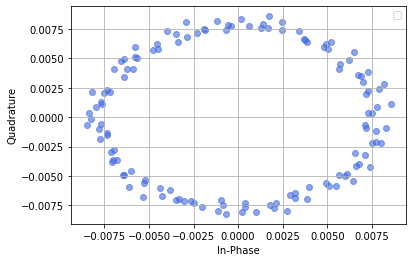

In [226]:
plt.figure() 
plt.grid()  # 坐标网格
plt.legend()    # 图例
plt.xlabel('In-Phase')  # x轴标题  
plt.ylabel('Quadrature')   # y轴标题
plt.scatter(X_train[i][0],X_train[i][1],color='royalblue', linewidth=1, alpha=0.6, label='Signal')
plt.savefig('con_%s'%lbl[train_idx[i]][0],dpi=300)

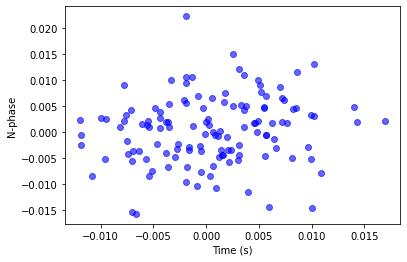

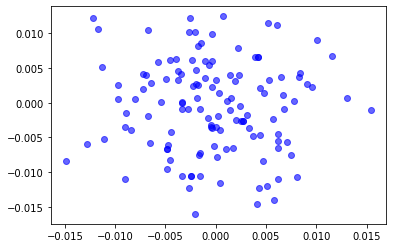

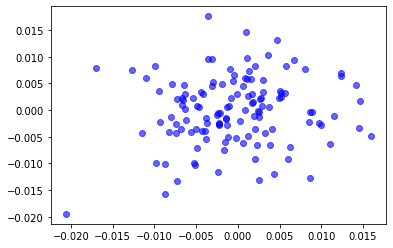

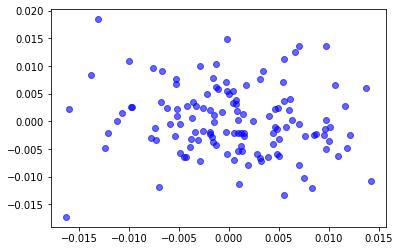

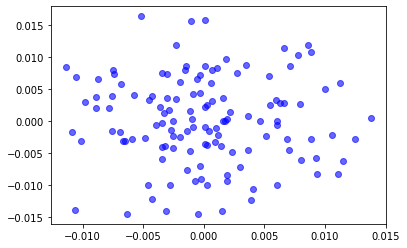

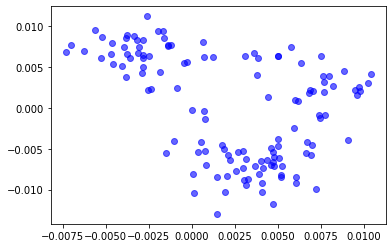

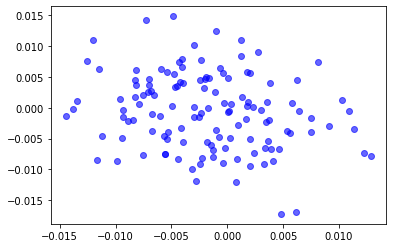

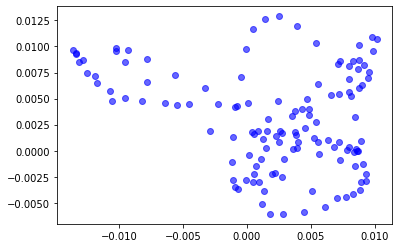

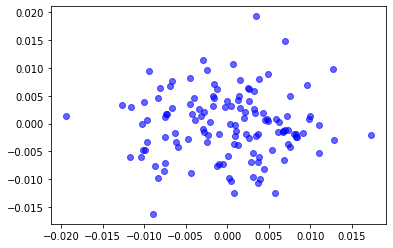

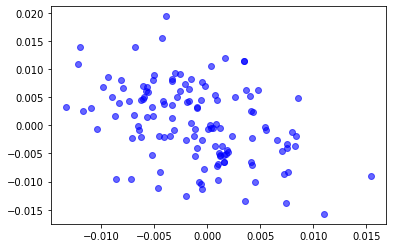

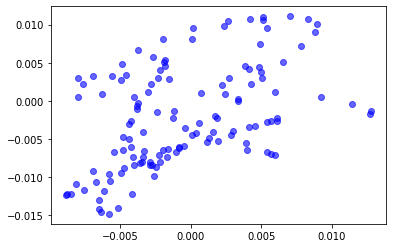

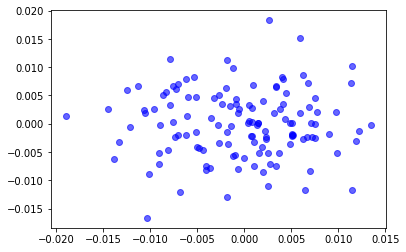

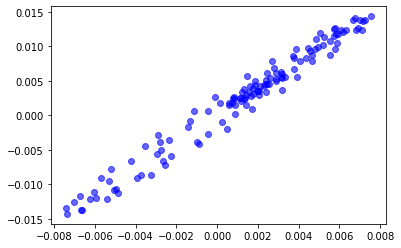

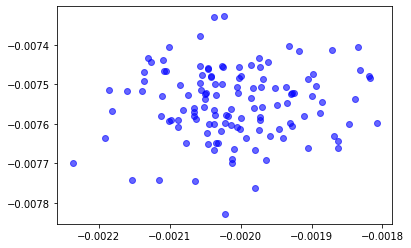

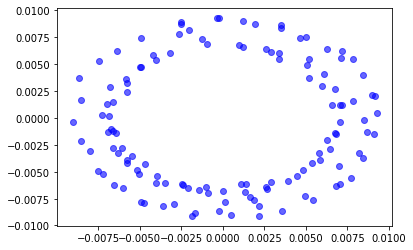

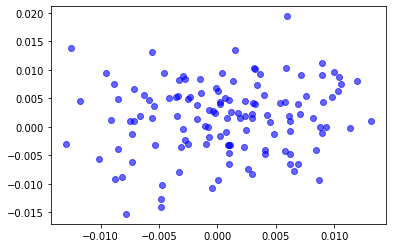

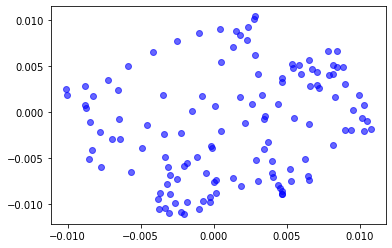

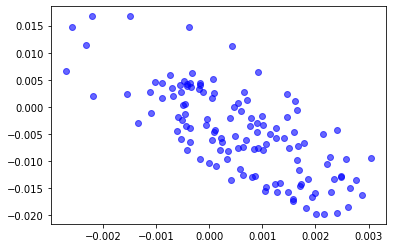

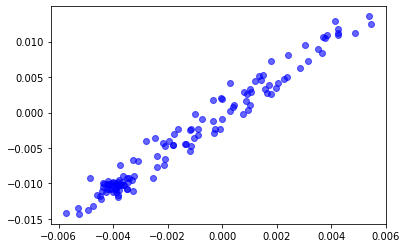

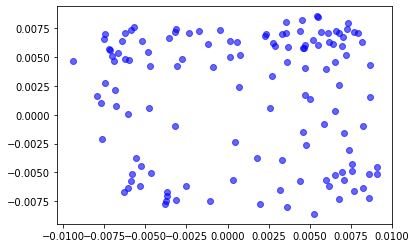

In [105]:
#plt.title('Type: %s, SNR: %d, PNR: %0.1f Noise: AWGN ' %(an,snr,pnr))
plt.ylabel('N-phase')
plt.xlabel('Time (s)')

#t = range(-2, 2)
#t = range(0, int(10000/8))

#ax.plot(t,X_train_awgn[sig][0], color='g', linewidth=1, alpha=0.6, label = 'AWGN')
#plt.legend(loc=0,ncol=1)

for i in range(20):
    plt.scatter(X_train[i][0],X_train[i][1],color='blue', linewidth=1, alpha=0.6, label='Signal')
    plt.show()
    #plt.savefig('con_%s.png' %lbl[i][0], dpi=300)
    i = i + 1

# AP

In [227]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [228]:
def AP(signal):
    x = signal[1]/signal[0]
    X_p = np.arctan(x)
    X_a = (signal[0]**2 + signal[1]**2)**0.5
    signal = np.stack((X_a,X_p), axis=0)
    return signal

In [229]:
def trans_to_AP(signal_set):
    for i in range(signal_set.shape[0]):
        signal_set[i] = AP(signal_set[i])
    return signal_set

In [230]:
X_train_AP = trans_to_AP(X_train_copy)
X_test_AP = trans_to_AP(X_test_copy)
X_train_AP.shape,X_test.shape

((110000, 2, 128), (110000, 2, 128))

In [284]:
# ('CPFSK', 10) 100
# ('PAM4', 10) 0
# ('QAM64', 10) 2
# ('QAM16', 10) 4
# ('GFSK', 10) 5
#
#
i = np.array(np.where(np.array(train_SNRs)==snr))[0][1992]
lbl[train_idx[i]]

('AM-DSB', 10)

No handles with labels found to put in legend.


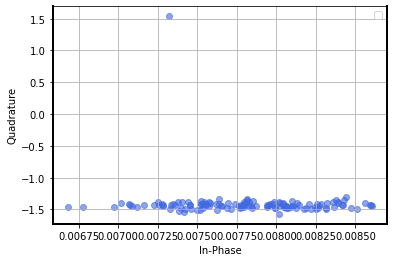

In [289]:
plt.figure() 
plt.grid()  # 坐标网格
plt.legend()    # 图例
plt.xlabel('In-Phase')  # x轴标题  
plt.ylabel('Quadrature')   # y轴标题
plt.scatter(X_train_AP[i][0],X_train_AP[i][1],color='royalblue', linewidth=1, alpha=0.6, label='Signal')
###设置坐标轴的粗细
ax=plt.gca();#获得坐标轴的句柄
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
#ax.spines['up'].set_linewidth(2);###设置右边坐标轴的粗细


plt.savefig('polar_%s'%lbl[train_idx[i]][0],dpi=300)



In [ ]:
#plt.title('Type: %s, SNR: %d, PNR: %0.1f Noise: AWGN ' %(an,snr,pnr))
plt.ylabel('N-phase')
plt.xlabel('X_a')

#t = range(-2, 2)
#t = range(0, int(10000/8))

#ax.plot(t,X_train_awgn[sig][0], color='g', linewidth=1, alpha=0.6, label = 'AWGN')
#plt.legend(loc=0,ncol=1)

for i in range(20,21):
    plt.scatter(X_a,X_p,color='b', linewidth=1, alpha=0.6, label='Signal')
    plt.show()

In [ ]:
#set Keras data format as channels_first
K.set_image_data_format('channels_last')
print(K.image_data_format())

def ConvBNReluUnit(input,kernel_size = 8,index = 0):
    x = Conv1D(filters=64, kernel_size=kernel_size, padding='same', activation='relu',kernel_initializer='glorot_uniform',
               name='conv{}'.format(index + 1))(input)
    # x = BatchNormalization(name='conv{}-bn'.format(index + 1))(x)
    x = MaxPool1D(pool_size=2, strides=2, name='maxpool{}'.format(index + 1))(x)
    return x

def CLDNNLikeModel(weights=None,
             input_shape=[128,2],
             classes=11,
             **kwargs):
    if weights is not None and not (os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), '
                         'or the path to the weights file to be loaded.')

    dr = 0.5  # dropout rate (%)
    tap = 8
    input = Input(input_shape,name='input')
    x = input

    #Cnvolutional Block
    L = 4
    for i in range(L):
        x = ConvBNReluUnit(x,kernel_size = tap,index=i)

    #LSTM Unit
    # batch_size,64,2
    x = LSTM(units=50,return_sequences = True)(x)
    x = LSTM(units=50)(x)

    #DNN
    x = Dense(128,activation='selu',name='fc1')(x)
    x = Dropout(dr)(x)
    x = Dense(128, activation='selu', name='fc2')(x)
    x = Dropout(dr)(x)
    x = Dense(classes,activation='softmax',name='softmax')(x)

    model = Model(inputs = input,outputs = x)

    # Load weights.
    if weights is not None:
        model.load_weights(weights)

    return model

model =CLDNNLikeModel(None,input_shape=[128,2])
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
#plot_model(model, to_file='model_CLDNN.png',show_shapes=True) # print model
model.summary()

In [ ]:
X_train_AP=X_train_AP.swapaxes(2,1)
X_test_AP = X_test_AP.swapaxes(2,1)
X_train_AP.shape,X_test_AP.shape

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

In [ ]:
# Set up some params 
nb_epoch = 50   # number of epochs to train on
batch_size = 1024  # training batch size

In [150]:
def scheduler(epoch):
    print("epoch({}) lr is {}".format(epoch, K.get_value(model.optimizer.lr)))
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

filepath = 'weights/CLDNN_dr0.5.h5'
history = model.fit(X_train_AP,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_test_AP, Y_test),
    callbacks = [reduce_lr,
                keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
                keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,patince=3,min_lr=0.000001),
                #keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
                ]
                    )

epoch(0) lr is 0.0010000000474974513
Epoch 1/50
  1/108 [..............................] - ETA: 0s - loss: 2.4024 - accuracy: 0.0898

D:\Anaconda3\envs\AMC\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


108/108 [==============================] - ETA: 0s - loss: 2.0877 - accuracy: 0.2274
Epoch 00001: val_loss improved from inf to 1.85751, saving model to weights\CLDNN_dr0.5.h5
108/108 [==============================] - 17s 155ms/step - loss: 2.0877 - accuracy: 0.2274 - val_loss: 1.8575 - val_accuracy: 0.3075
epoch(1) lr is 0.0010000000474974513
Epoch 2/50
108/108 [==============================] - ETA: 0s - loss: 1.8110 - accuracy: 0.3207
Epoch 00002: val_loss improved from 1.85751 to 1.75997, saving model to weights\CLDNN_dr0.5.h5
108/108 [==============================] - 15s 140ms/step - loss: 1.8110 - accuracy: 0.3207 - val_loss: 1.7600 - val_accuracy: 0.3347
epoch(2) lr is 0.0010000000474974513
Epoch 3/50
108/108 [==============================] - ETA: 0s - loss: 1.7212 - accuracy: 0.3480
Epoch 00003: val_loss improved from 1.75997 to 1.67247, saving model to weights\CLDNN_dr0.5.h5
108/108 [==============================] - 15s 143ms/step - loss: 1.7212 - accuracy: 0.3480 - val_lo

In [ ]:
# Show simple version of performance
score = model.evaluate(X_test_AP, Y_test_AP, verbose=0, batch_size=batch_size)
print(score)

In [ ]:
# Show loss curves 
plt.figure()
plt.title('CLDNN Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

# FFT

In [18]:
def plot_fft(signal):
    # 画fft图
    fs = 1   # 采样频率
    y = signal
    xf = np.fft.fft(y)   # 对离散数据y做fft变换得到变换之后的数据xf
    xfp = np.fft.fftfreq(len(y), d=1 / fs)  # fftfreq(length，fs)，计算得到频率
    xf = abs(xf) # 将复数求模，得到fft的幅值

    plt.figure(figsize=(10,3))
    #ax1 = plt.subplot(1,5,12)
    plt.plot(xfp, xf)# 画fft图像，横坐标为频率，纵坐标为幅值
    plt.xlabel('f(Hz)') 
    plt.ylabel('Amp')
    plt.title('fft')

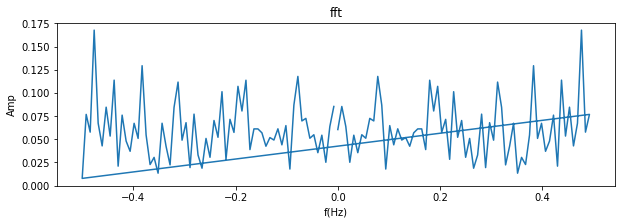

In [19]:
for i in range(1):
    plot_fft(X_train[i][0])

# 时频图

In [18]:
import scipy.signal as signal
def stft(x, **params):
    '''
    :param x: 输入信号
    :param params: {fs:采样频率；
                    window:窗。默认为汉明窗；
                    nperseg： 每个段的长度，默认为256，
                    noverlap:重叠的点数。指定值时需要满足COLA约束。默认是窗长的一半，
                    nfft：fft长度，
                    detrend：（str、function或False）指定如何去趋势，默认为Flase，不去趋势。
                    return_onesided：默认为True，返回单边谱。
                    boundary：默认在时间序列两端添加0
                    padded：是否对时间序列进行填充0（当长度不够的时候），
                    axis：可以不必关心这个参数}
    :return: f:采样频率数组；t:段时间数组；Zxx:STFT结果
    '''
    f, t, zxx = signal.stft(x, **params) 
    return f, t, zxx

D:\Anaconda3\envs\AMC\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=128).
  """Entry point for launching an IPython kernel.


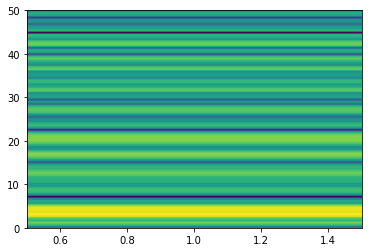

In [43]:
plt.specgram(X_train[1001][0], NFFT=200, Fs=100, noverlap=100)
plt.show()

D:\Anaconda3\envs\AMC\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=200) >= signal length (=128).
  """Entry point for launching an IPython kernel.


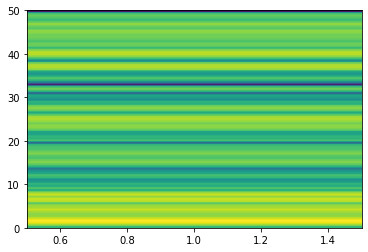

In [42]:
plt.specgram(X_train[1001][1], NFFT=200, Fs=100, noverlap=100)
plt.show()

In [19]:
import matplotlib.pyplot as plt
def stft_specgram(x, picname=None, **params):    #picname是给图像的名字，为了保存图像
    f, t, zxx = stft(x, **params)
    plt.pcolormesh(t, f, np.abs(zxx))
    plt.colorbar()
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.tight_layout()
    if picname is not None:
        plt.savefig('..\\picture\\' + str(picname) + '.jpg')       #保存图像
    plt.show()      #清除画布
    return t, f, zxx

D:\Anaconda3\envs\AMC\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.


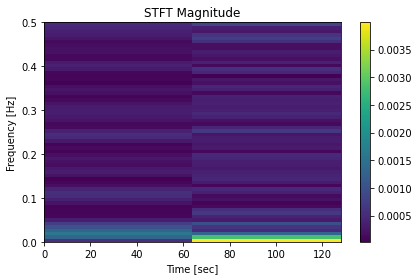

In [22]:
t, f, zxx = stft_specgram(X_train[19999][1])

# 高阶累积量

In [27]:
signal = X_train[0][0]

In [56]:
def get_cumulants(signal):
    L = 128
    
    M20 = sum(np.power(signal,2))/L # M20 = sum(signalData(row,:).^2)/L;
    M21 = sum(np.power(abs(signal),2))/L # M21 = sum(abs(signal).^2)/L;
    M22 = sum(np.power(np.conj(signal),2))/L # M22 = sum(conj(signal).^2)/L;
    
        
    M40 = sum(np.power(signal,4))/L # M40 = sum(signalData(row,:).^4)/L;
    M41 = sum(np.multiply(np.power(abs(signal),2),np.power(signal,2)))/L # M41 = sum(abs(signalData(row,:)).^2.*signalData(row,:).^2)/L;
    M42 = sum(np.power(abs(signal),4))/L # M42 = sum(abs(signalData(row,:)).^4)/L;
    M43 = sum(np.multiply(np.power(abs(signal),2),np.power(np.conj(signal),2)))/L # M43 = sum(abs(signalData(row,:)).^2.*conj((signalData(row,:))).^2)/L;
    
    C20 = M20
    C21 = M21
    C40 = M40 - (3*M20)**2
    C41 = M41 - 3*M20*M21
    C42 = M42 - abs(M20)**2 - (2*M21)**2
    
    #C21_modify = C21 - var(noiseData,ddof= 1)
    
#     C20_norm = C20/(C21_modify^2);
#     C21_norm = C21/(C21_modify^2);
#     C40_norm = C40/(C21_modify^2);
#     C41_norm = C41/(C21_modify^2);
#     C42_norm = C42/(C21_modify^2);
#     C60_norm = C60/(C21_modify^2);
#     C61_norm = C61/(C21_modify^2);
#     C62_norm = C62/(C21_modify^2);
#     C63_norm = C63/(C21_modify^2);


    print(C20,C21,C40,C41,C42)
    return C20,C21,C40,C41,C42
    

In [139]:
def get_cumulants(signal):

    siganl_2cum = np.power(signal,2)#Sig.^2
    siganl_3cum = np.power(signal,3)#Sig.^3
    siganl_4cum = np.power(signal,4)#Sig.^4
    abs_siganl_4cum = np.power(abs(signal),4) #abs(Sig).^4
    
    sig_conj = np.conj(signal) # conj(Sig)

    C20 = np.mean(siganl_2cum)
    C21 = np.mean(np.power(abs(signal),2))

    M40 = np.mean(siganl_4cum)
    C40 = M40 - (3*C20)**2
    C41 = np.mean(np.multiply(siganl_3cum,sig_conj)) - 3*C20*C21
    C42 = np.mean(abs_siganl_4cum) - abs(C20)**2 - (2*C21)**2
    
    print(C20,C21,C40,C41,C42)
    return C20,C21,C40,C41,C42

In [140]:
def df_HOC(Sig):
    df = []
    for i in range(Sig.shape[0]):
        signal = Sig[i]
        C20,C21,C40,C41,C42 = get_cumulants(signal)
        df.append([C20,C21,C40,C41,C42])
    df = pd.DataFrame(df)
    return df

In [136]:
X_train_HOC = df_HOC(X_train)
X_test_HOC = df_HOC(X_test)

In [163]:
signal = X_train[2000][0]
C20,C21,C40,C41,C42 = get_cumulants(signal)
F1 = (abs(C42) + abs(C40))/np.power(abs(C21),2)
F4 = (abs(C42) - abs(C40))/np.power(abs(C21),2)

3.549676e-05 3.549676e-05 -7.910212543302348e-09 -3.5009286302829364e-10 -2.8701327564529786e-09


In [159]:
signal = X_train[2000]
C20,C21,C40,C41,C42 = get_cumulants(signal)
F1 = (abs(C42) + abs(C40))/np.power(abs(C21),2)
F4 = (abs(C42) - abs(C40))/np.power(abs(C21),2)

3.8200713e-05 3.8200713e-05 -9.08087606400046e-09 -3.25109277131336e-10 -3.2436982060877107e-09


In [172]:
x_r = np.conjugate(X_train)
M20 = np.mean(np.power(X_train, 2), axis = 2, keepdims = True)

In [174]:
M20.shape

(110000, 2, 1)

In [175]:
def accumulat_features(x): # accumulation feature and the input is complex
    
    x_r = np.conjugate(x)

    M20 = np.mean(np.power(x, 2), axis = 2, keepdims = True)
    M21 = np.mean(np.power(np.abs(x), 2), axis = 2, keepdims = True)
    M22 = np.mean(np.power(x_r, 2), axis = 2, keepdims = True)
    M40 = np.mean(np.power(x, 4), axis = 2, keepdims = True)
    M41 = np.mean(np.power(np.abs(x), 2)*np.power(x, 2), axis = 2, keepdims = True)
    M42 = np.mean(np.power(np.abs(x), 4), axis = 2, keepdims = True)
    M43 = np.mean(np.power(np.abs(x), 2)*np.power(x_r, 2), axis = 2, keepdims = True)
    M60 = np.mean(np.power(x, 6), axis = 2, keepdims = True)
    M63 = np.mean(np.power(np.abs(x), 6), axis = 2, keepdims = True)
    M80 = np.mean(np.power(x, 8), axis = 2, keepdims = True)

    C20 = M20
    C21 = M21
    C40 = M40 - 3*np.power(M20, 2)
    C41 = M41 - 3*M20*M21
    C42 = M42 - np.power(np.abs(M20), 2) - 2*np.power(M21, 2)
    C60 = M60 - 15*M20*M40 + 30*np.power(M20, 3)
    C63 = M63 - 6*M41*M20 - 9*M42*M21 + 18*M20*M20*M21 + 12*np.power(M21, 3)
    C80 = M80 - 28*M20*M60 - 35*M40*M40 + 420*M20*M20*M40 - 630*np.power(M20, 4)

    T1 = np.abs(C80) / np.power(np.abs(C42), 2)
    T2 = np.abs(C80) / np.power(np.abs(C40), 2) # 利用差分（x(k+1) - x(k)）可区分QPSK/OQPSK
    M1 = np.abs(C40) / np.abs(C42)
    M2 = np.power(np.abs(C63), 2) / np.power(np.abs(C42), 3)

    C20_norm = np.abs(C20/C21)
    C40_norm = np.abs(C40/np.power(C21, 2))
    C41_norm = np.abs(C41/np.power(C21, 2))
    C42_norm = np.abs(C42/np.power(C21, 2))
    C60_norm = np.abs(C60/np.power(C21, 3))
    C63_norm = np.abs(C63/np.power(C21, 3))
    C80_norm = np.abs(C80/np.power(C21, 4))

    return [T1, T2, M1, M2, C20_norm, C40_norm, C41_norm, C42_norm, C60_norm, C63_norm, C80_norm]    

In [179]:
[T1, T2, M1, M2, C20_norm, C40_norm, C41_norm, C42_norm, C60_norm, C63_norm, C80_norm] = accumulat_features(X_train)

D:\Anaconda3\envs\AMC\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda3\envs\AMC\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


# 基础特征

In [189]:
# part one: basic feature 
def element_mean(x):
    return np.mean(x, axis=2, keepdims=True)

def element_abs_mean(x):
    return np.abs(np.mean(x, axis=2, keepdims=True))

def element_std(x):
    return np.std(x,axis=2,keepdims=True)

def element_std_abs(x):
    return np.std(np.abs(x),axis=2,keepdims=True)  

def abs_max_mins_min(x):
    return np.abs(np.max(x, axis=2, keepdims=True) - np.min(x, axis=2, keepdims=True))

def max_mins_min_abs(x):
    return np.max(np.abs(x), axis=2, keepdims=True) - np.min(np.abs(x), axis=2, keepdims=True)

def abs_mean_sqr(x):
    return np.abs(np.mean(np.square(x), axis = 2, keepdims=True))

def mean_sqr_abs(x):
    return np.mean(np.square(np.abs(x)), axis = 2, keepdims=True)

def abs_sqrmean_mis_meansqr(x):
    return np.abs(np.mean(np.square(x),axis=2,keepdims=True)- \
            np.square(np.mean(x,axis = 2,keepdims=True)))
    
def sqrmean_mis_meansqr_abs(x):
    return np.mean(np.square(np.abs(x)),axis=2,keepdims=True)- \
            np.square(np.mean(np.abs(x),axis = 2,keepdims=True))

def abs_fourmean_mis_meanfour(x):
    return np.abs(np.mean(np.power(x,4),axis=2,keepdims=True)-\
            np.mean(np.square(x),axis=2,keepdims=True)**2) 

def fourmean_mis_meanfour_abs(x):
    return np.mean(np.power(np.abs(x),4),axis=2,keepdims=True)-\
            np.mean(np.square(np.abs(x)),axis=2,keepdims=True)**2

# 时间序列特征

In [247]:

# part two: time sequence feature

def absolute_sum_of_changes(x):
    return np.sum(np.abs(np.diff(x,1)), axis=2, keepdims=True)

def agg_autocorrelation(x, l=1):    ##
    x_var = np.var(x, axis=2, keepdims=True)
    x_diff_sum = np.sum(np.diff(x-np.mean(x, axis=2, keepdims=True),l), axis=2, keepdims=True)
    return x_diff_sum / x_var

def approximate_entropy(x):
    return np.sum(-x*np.log(np.abs(x+0.0000001)), axis=2, keepdims=True)

def autocorrelation(x, k=1):
    n = x.shape[2]
    variance = np.var(x, axis=2, keepdims=True)+0.0000001
    x = x-np.mean(x, axis=2, keepdims=True)
    result = np.sum(x[:,:,k:]*x[:,:,:n-k], axis=2, keepdims=True) / (variance*(n-k))
    return result

def cwt_coefficients(x):
    ricker = (1-x**2/4)*np.exp(-x**2/8)
    result = np.mean(ricker, axis=2, keepdims=True)
    return result

def count_above_mean(x):
    mask = (x - np.mean(x, axis=2, keepdims=True))>0
    result = np.sum(mask, axis=2, keepdims=True)
    return result

def count_below_mean(x):
    mask = (x - np.mean(x, axis=2, keepdims=True))<0
    result = np.sum(mask, axis=2, keepdims=True)
    return result

def first_location_of_maximum(x): ##
    result = np.argmax(x, axis=2)
    return result.reshape(result.shape[0], result.shape[1], 1)

def first_location_of_minimum(x): ##
    result = np.argmin(x, axis=2)
    return result.reshape(result.shape[0], result.shape[1], 1)

def kurtosis(x):
    x = x - np.mean(x, axis=2, keepdims=True)
    e4 = np.mean(pow(x, 4), axis=2, keepdims=True)
    e2 = pow(np.mean(pow(x, 2), axis=2, keepdims=True),2)
    result = e4/e2
    return result

def skewness(x):
    variance = np.var(x, axis=2, keepdims=True)+0.0000001
    x = x - np.mean(x, axis=2, keepdims=True)
    result = np.mean(pow(x/variance, 3), axis=2, keepdims=True)
    return result

# 调制相关特征

In [248]:
# feature function
# part three: modulation feature

def max_amp_density_abs(X_complex_abs):
    
    # The maximum value of the normalized spectral density of the amplitude with Zero Center
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    Acn_complex_max = np.max(np.abs(np.fft.fft(Acn,axis=2))**2, axis = 2, keepdims = True) / X_complex_abs.shape[2]
    return Acn_complex_max
    
def std_phase_abs(X_complex_angl, X_complex_abs):
    # Standard deviation of absolute value of instantaneous phase nonlinear component at zero Center
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    angl_mins_mean = X_complex_angl - np.mean(X_complex_angl,axis=2,keepdims=True)
    angl_mins_mean_after_mask = angl_mins_mean * sqr_mask
    result = np.sqrt(np.sum(np.square(angl_mins_mean_after_mask),axis=2,keepdims=True)/sqr_mask_sum -
                                     (np.sum(np.abs(angl_mins_mean_after_mask),axis=2,keepdims=True)/sqr_mask_sum)**2)
    return result

def std_phase(X_complex_angl, X_complex_abs):
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    angl_mins_mean = X_complex_angl - np.mean(X_complex_angl,axis=2,keepdims=True)
    angl_mins_mean_after_mask = angl_mins_mean * sqr_mask
    result = np.sqrt(np.sum(np.square(angl_mins_mean_after_mask),axis=2,keepdims=True)/sqr_mask_sum - 
                                     (np.sum(angl_mins_mean_after_mask,axis=2,keepdims=True)/sqr_mask_sum)**2) 
    return result

def std_amp_abs(X_complex_abs):
    
    # Standard deviation of instantaneous amplitude absolute value of Zero Center normalized non weak signal
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    result = np.sqrt(np.mean(np.square(Acn),axis=2,keepdims=True) - 
                                     np.mean(np.abs(Acn),axis=2,keepdims=True)**2) 
    return result

def std_fre_abs(X_complex_fre, X_complex_abs):
    # Standard deviation of instantaneous frequency absolute value of Zero Center normalized non weak signal
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    fn = X_complex_fre - np.mean(X_complex_fre,axis=2,keepdims=True)
    fn_after_mask = fn * sqr_mask
    result = np.sqrt(np.sum(np.square(fn_after_mask),axis=2,keepdims=True)/sqr_mask_sum - 
                                     (np.sum(np.abs(fn_after_mask),axis=2,keepdims=True)/sqr_mask_sum)**2) 
    return result

def std_amp(X_complex_abs):
    # Standard deviation of instantaneous amplitude of Zero Center normalized non weak signal
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    sqr_mask = Acn > 0.05
    sqr_mask[:,:,0] = True
    sqr_mask_sum = np.sum(sqr_mask,axis=2,keepdims=True)
    Acn_after_mask = Acn * sqr_mask
    result = np.sqrt(np.sum(np.square(Acn_after_mask),axis=2,keepdims=True)/sqr_mask_sum - 
                                     (np.sum(Acn_after_mask,axis=2,keepdims=True)/sqr_mask_sum)**2) 
    return result    

def den_amp(X_complex_abs):
    # Compactness of Zero Center normalized instantaneous amplitude
    Acn = X_complex_abs / np.mean(X_complex_abs, axis=2, keepdims = True) - 1
    result = np.mean(np.power(Acn, 4),axis=2,keepdims=True) / np.mean(np.square(Acn),axis=2,keepdims=True)**2 
    return result 

def den_fre(X_complex_fre):
    # Compactness of Zero Center normalized instantaneous frequency
    fn = X_complex_fre - np.mean(X_complex_fre,axis=2,keepdims=True)
    result = np.mean(np.power(fn, 4),axis=2,keepdims=True) / np.mean(np.square(fn),axis=2,keepdims=True)**2 
    return result 